WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Device: cpu
floatX: float64
Loading data...
Data head:
   id  item  t  Y
0   1     1  1  0
1   1     2  1  0
2   1     3  1  0
3   1     4  1  0
4   1     5  1  1

Dataset summary:
Number of experts: 20
Number of cases: 50
Number of observations: 2000

Building model...

Sampling...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]


Posterior Summary:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_c    3.119  0.397   2.410    3.888      0.004    0.003   12088.0   
sigma_l    1.830  0.332   1.246    2.461      0.003    0.002   15153.0   
sigma_p    1.182  0.278   0.662    1.706      0.003    0.002    6774.0   
sigma_o    0.372  0.281   0.000    0.877      0.004    0.003    5349.0   
intercept -4.792  0.741  -6.235   -3.454      0.009    0.007    6397.0   

           ess_tail  r_hat  
sigma_c     22541.0    1.0  
sigma_l     25200.0    1.0  
sigma_p      7196.0    1.0  
sigma_o      8618.0    1.0  
intercept   13498.0    1.0  

Creating visualizations...


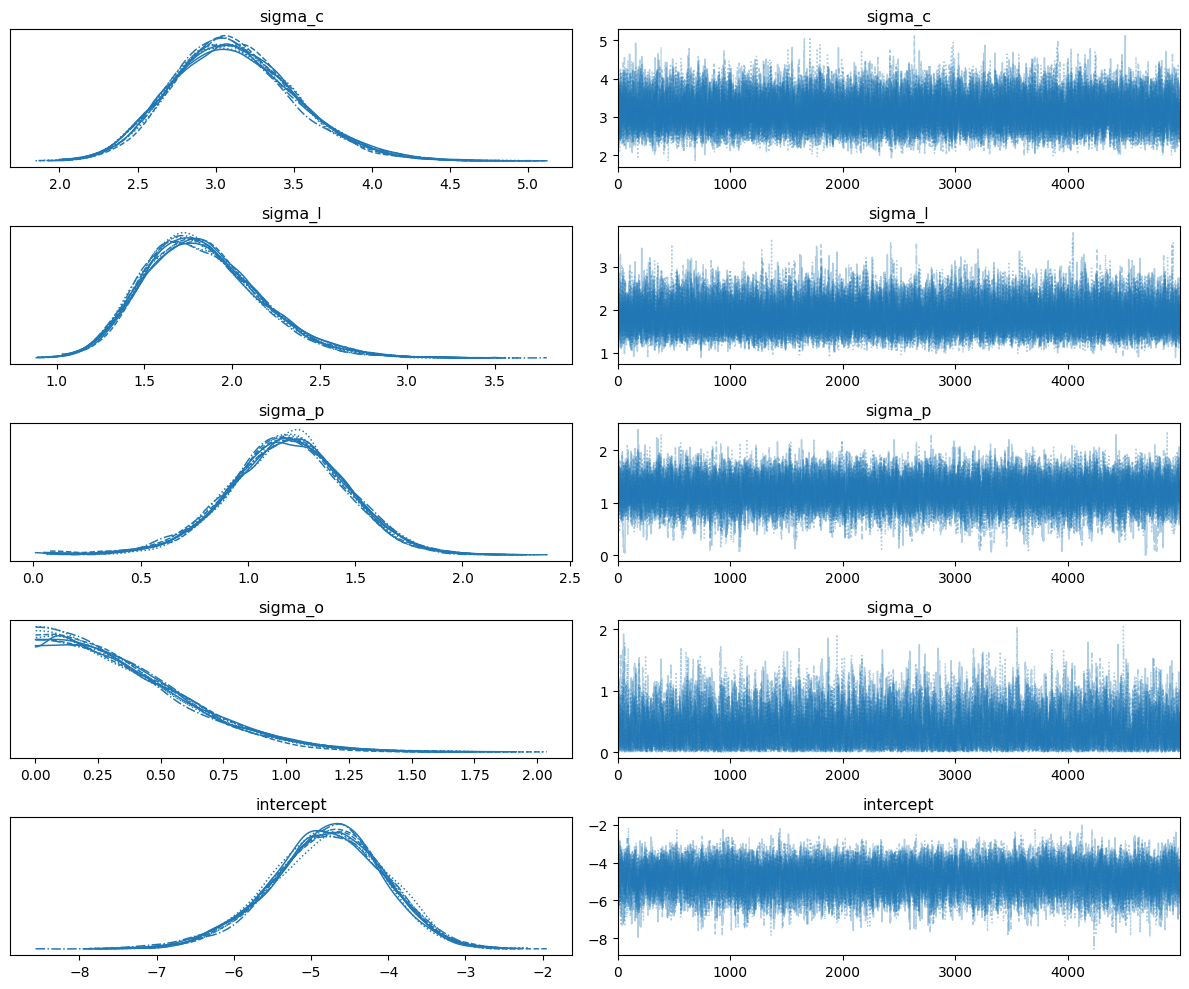

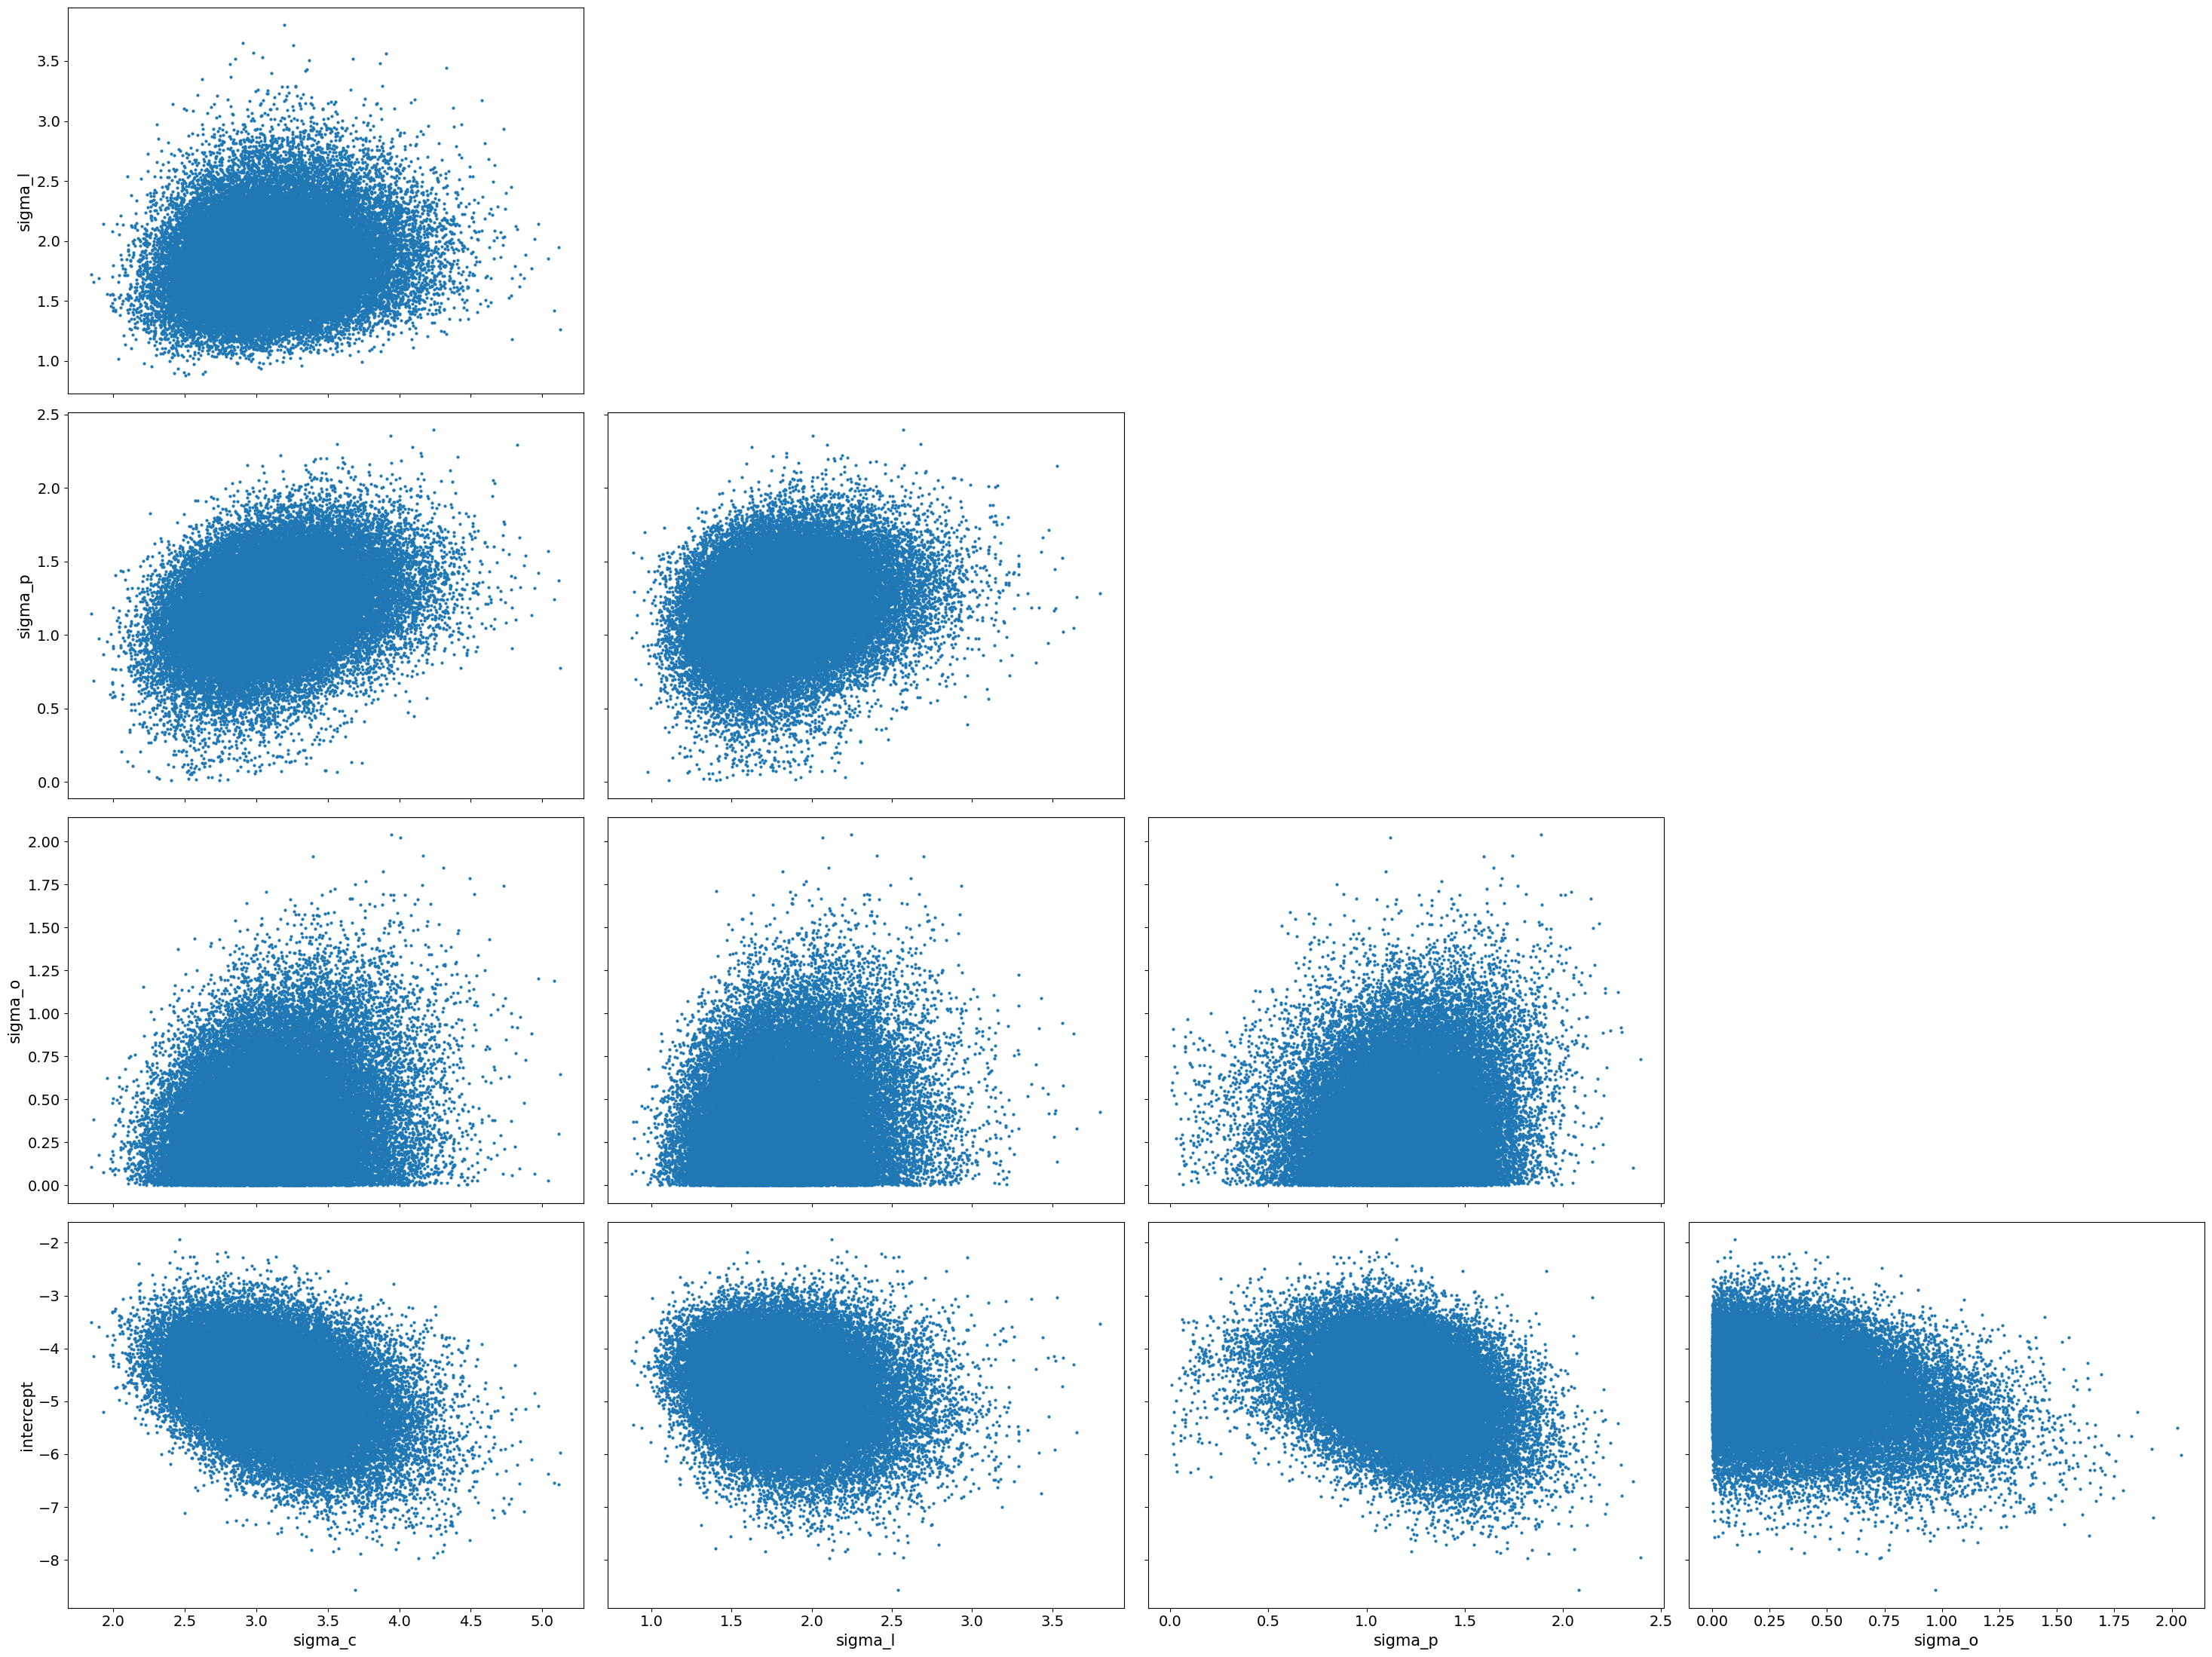

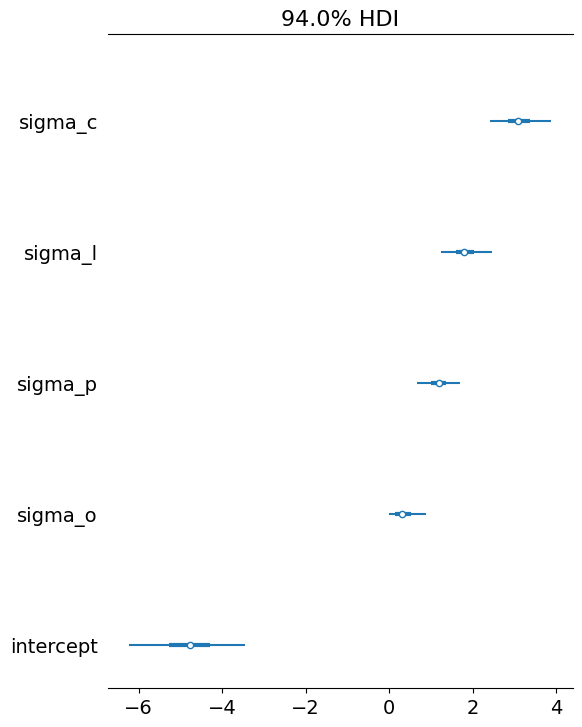


Diagnostic Statistics:
R-hat statistics:
<xarray.Dataset>
Dimensions:    (z_c_dim_0: 50, z_l_dim_0: 20, z_p_dim_0: 20, z_p_dim_1: 50,
                z_o_dim_0: 2000, c_dim_0: 50, l_dim_0: 20, p_dim_0: 20,
                p_dim_1: 50, o_dim_0: 2000)
Coordinates:
  * z_c_dim_0  (z_c_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * z_l_dim_0  (z_l_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
  * z_p_dim_0  (z_p_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
  * z_p_dim_1  (z_p_dim_1) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * z_o_dim_0  (z_o_dim_0) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * c_dim_0    (c_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * l_dim_0    (l_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * p_dim_0    (p_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * p_dim_1    (p_dim_1) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * o_dim_0    (o

In [1]:
import os

# Set PyTensor flags before any PyTensor-related imports
os.environ["PYTENSOR_DEVICE"] = "cpu"
os.environ["PYTENSOR_FLOATX"] = "float64"
os.environ["PYTENSOR_COMPUTE_TEST_VALUE"] = "ignore"

# Now import your libraries
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pytensor
import warnings
warnings.filterwarnings('ignore')

# (Optional) Verify that configuration is set
print("Device:", pytensor.config.device)
print("floatX:", pytensor.config.floatX)

# (Optional) Custom callback for diagnostic monitoring
class DiagnosticsCallback:
    def __init__(self, monitor_vars):
        self.monitor_vars = monitor_vars
        self.samples = {var: [] for var in monitor_vars}
        
    def __call__(self, trace, draw):
        try:
            if draw % 100 == 0:  # Update every 100 samples
                print(f"\nDraw {draw}")
                for var in self.monitor_vars:
                    value = trace.get_values(var)[-1] if hasattr(trace, 'get_values') else trace[-1][var]
                    self.samples[var].append(value)
                    print(f"{var}: {value:.3f}")
                    
                if len(self.samples[self.monitor_vars[0]]) > 1:
                    print("\nRough convergence check:")
                    for var in self.monitor_vars:
                        values = np.array(self.samples[var])
                        print(f"{var} std/mean: {np.std(values)/np.mean(values):.3f}")
        except Exception as e:
            print(f"Warning: DiagnosticsCallback error: {e}")

# Load and prepare data
print("Loading data...")
data = pd.read_csv("dataQ1.csv")
print("Data head:")
print(data.head())

# Create integer indices
data['expert_idx'] = pd.Categorical(data['id']).codes
data['case_idx'] = pd.Categorical(data['item']).codes
data['occ_idx'] = pd.Categorical(data['t']).codes

# Get dimensions
n_experts = data['expert_idx'].nunique()
n_cases = data['case_idx'].nunique()
n_obs = data.shape[0]

print("\nDataset summary:")
print(f"Number of experts: {n_experts}")
print(f"Number of cases: {n_cases}")
print(f"Number of observations: {n_obs}")

# Build and sample from the PyMC model using non-centered parameterizations for all latent variables
print("\nBuilding model...")
with pm.Model() as model:
    # Priors for scale parameters
    sigma_c = pm.HalfNormal("sigma_c", sigma=1)
    sigma_l = pm.HalfNormal("sigma_l", sigma=1)
    sigma_p = pm.HalfNormal("sigma_p", sigma=1)
    sigma_o = pm.HalfNormal("sigma_o", sigma=1)
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Non-centered latent variables for cases, experts, and their interactions
    z_c = pm.Normal("z_c", mu=0, sigma=1, shape=n_cases)
    c = pm.Deterministic("c", z_c * sigma_c)
    
    z_l = pm.Normal("z_l", mu=0, sigma=1, shape=n_experts)
    l = pm.Deterministic("l", z_l * sigma_l)
    
    z_p = pm.Normal("z_p", mu=0, sigma=1, shape=(n_experts, n_cases))
    p = pm.Deterministic("p", z_p * sigma_p)
    
    # Non-centered parameterization for observation-level effects:
    z_o = pm.Normal("z_o", mu=0, sigma=1, shape=n_obs)
    o = pm.Deterministic("o", z_o * sigma_o)
    
    # Linear predictor: use the indices as before.
    z = (intercept +
         c[data['case_idx'].values] +
         l[data['expert_idx'].values] +
         p[data['expert_idx'].values, data['case_idx'].values] +
         o)
    
    # Likelihood
    y_obs = pm.Bernoulli("y_obs", logit_p=z, observed=data['Y'].values)
    
    # Setup monitoring for selected parameters
    monitor_vars = ['sigma_c', 'sigma_l', 'sigma_p', 'sigma_o', 'intercept']
    diagnostics = DiagnosticsCallback(monitor_vars)
    # Note: We are not using a live trace callback, so no callback is passed to pm.sample()
    
    print("\nSampling...")
    trace = pm.sample(
        draws=5000,            # Increased number of draws
        tune=2000,             # Further increased tuning steps
        chains=10,              # Run 4 chains
        cores=6,               # Use 4 cores
        random_seed=42,
        return_inferencedata=True,
        nuts_sampler='numpyro',  # Use NumPyro sampler
        init='jitter+adapt_diag',
        progressbar=True,
        target_accept=0.98      # Slightly higher target acceptance rate
    )

# Post-sampling analysis
print("\nPosterior Summary:")
summary = az.summary(trace, var_names=monitor_vars)
print(summary)

# Visualizations: only final diagnostic plots will be shown
print("\nCreating visualizations...")
try:
    # Trace plots
    az.plot_trace(trace, var_names=monitor_vars)
    plt.tight_layout()
    plt.show()

    # Parameter correlation plot
    az.plot_pair(
        trace,
        var_names=monitor_vars,
        kind='scatter'
    )
    plt.tight_layout()
    plt.show()

    # Forest plot
    az.plot_forest(
        trace,
        var_names=monitor_vars,
        combined=True
    )
    plt.show()

    # Print additional diagnostics
    print("\nDiagnostic Statistics:")
    print("R-hat statistics:")
    print(az.rhat(trace))
    print("\nEffective sample size:")
    print(az.ess(trace))
except Exception as e:
    print(f"Visualization error: {e}")


# Get percent variance explained by each component - signal and noises

# Extract posterior samples for the scale parameters (flattening across chains and draws)
sigma_c_samples = trace.posterior['sigma_c'].values.flatten()
sigma_l_samples = trace.posterior['sigma_l'].values.flatten()
sigma_p_samples = trace.posterior['sigma_p'].values.flatten()
sigma_o_samples = trace.posterior['sigma_o'].values.flatten()

# Compute the variance for each component (variance = sigma^2)
var_c = np.mean(sigma_c_samples ** 2)
var_l = np.mean(sigma_l_samples ** 2)
var_p = np.mean(sigma_p_samples ** 2)
var_o = np.mean(sigma_o_samples ** 2)

# Calculate the total variance as the sum of the four component variances
total_variance = var_c + var_l + var_p + var_o

# Compute percentage contributions
perc_c = (var_c / total_variance) * 100
perc_l = (var_l / total_variance) * 100
perc_p = (var_p / total_variance) * 100
perc_o = (var_o / total_variance) * 100

# Print the results
print("\nVariance Decomposition:")
print(f"Total Variance (sum of components): {total_variance:.3f}")
print("Percentage contributions:")
print(f"  Signal (case) variance:         {perc_c:.2f}%")
print(f"  Level noise (expert) variance:    {perc_l:.2f}%")
print(f"  Pattern noise (interaction) variance: {perc_p:.2f}%")
print(f"  Occasion noise (observation-level) variance: {perc_o:.2f}%")


In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# --------------------------
# Posterior Predictive Sampling
# --------------------------
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"], random_seed=42)
    
# Extract the y_obs array from the posterior_predictive group.
# Shape: (n_chain, n_draw, n_obs)
y_obs_ppc = ppc.posterior_predictive["y_obs"].values
n_chain, n_draw, n_obs = y_obs_ppc.shape
# Combine chains and draws into one dimension:
y_obs_ppc = y_obs_ppc.reshape((n_chain * n_draw, n_obs))
n_samples = y_obs_ppc.shape[0]

# Ensure the original data has an index.
data = data.copy()
data["obs_index"] = np.arange(data.shape[0])

# --------------------------
# Diagnostic 1: Percentage of "Epilepsy" Responses by Expert and Occasion
# --------------------------
# Compute observed percentages.
obs_pct = data.groupby(["id", "t"])["Y"].mean().reset_index()
obs_pct.rename(columns={"Y": "pct_obs"}, inplace=True)

# Create a DataFrame linking each observation with its expert and occasion.
obs_info = data[["obs_index", "id", "t"]].set_index("obs_index")

ppc_list = []
for s in range(n_samples):
    sample_df = pd.DataFrame({
        "obs_index": np.arange(data.shape[0]),
        "y_pred": y_obs_ppc[s]
    }).set_index("obs_index")
    sample_df = sample_df.join(obs_info)
    sample_summary = sample_df.groupby(["id", "t"])["y_pred"].mean().reset_index()
    sample_summary["sample"] = s
    ppc_list.append(sample_summary)
    
ppc_summary = pd.concat(ppc_list, axis=0)
ppc_stats = ppc_summary.groupby(["id", "t"])["y_pred"].agg(
    mean_pred="mean",
    lower=lambda x: np.percentile(x, 2.5),
    upper=lambda x: np.percentile(x, 97.5)
).reset_index()

compare_pct = pd.merge(obs_pct, ppc_stats, on=["id", "t"])

# Scatterplot: Observed vs. Predicted % "Epilepsy" responses.
fig, ax = plt.subplots(figsize=(8,6))
for occ in sorted(compare_pct["t"].unique()):
    sub = compare_pct[compare_pct["t"] == occ]
    ax.errorbar(sub["pct_obs"]*100, sub["mean_pred"]*100,
                yerr=[(sub["mean_pred"] - sub["lower"])*100,
                      (sub["upper"] - sub["mean_pred"])*100],
                fmt="o", label=f"Occasion {occ}", alpha=0.7)
ax.plot([0,40], [0,40], "k--", label="Identity")
ax.set_xlim(0, 40)
ax.set_ylim(0, 40)
ax.set_xlabel("Observed % 'Epilepsy' Responses")
ax.set_ylabel("Predicted % 'Epilepsy' Responses")
ax.set_title("Observed vs. Predicted % 'Epilepsy' Responses")
ax.legend()
plt.tight_layout()
plt.show()

# --------------------------
# Diagnostic 2: Response Change Between Occasions
# --------------------------
# Pivot observed data so each row corresponds to a case for a given expert.
pivot_data = data.pivot(index=["id", "item"], columns="t", values="Y").reset_index()
pivot_data.columns = ["id", "item", "Y_occasion1", "Y_occasion2"]
pivot_data["changed"] = (pivot_data["Y_occasion1"] != pivot_data["Y_occasion2"]).astype(int)
obs_change = pivot_data.groupby("id")["changed"].mean().reset_index()
obs_change.rename(columns={"changed": "pct_change_obs"}, inplace=True)

ppc_change_list = []
for s in range(n_samples):
    sample_preds = pd.DataFrame({
        "obs_index": np.arange(data.shape[0]),
        "y_pred": y_obs_ppc[s]
    }).set_index("obs_index")
    sample_preds = sample_preds.join(data[["obs_index", "id", "item", "t"]].set_index("obs_index"))
    sample_pivot = sample_preds.pivot(index=["id", "item"], columns="t", values="y_pred").reset_index()
    sample_pivot.columns = ["id", "item", "y_pred_occ1", "y_pred_occ2"]
    sample_pivot["changed"] = (sample_pivot["y_pred_occ1"] != sample_pivot["y_pred_occ2"]).astype(int)
    sample_summary = sample_pivot.groupby("id")["changed"].mean().reset_index()
    sample_summary["sample"] = s
    ppc_change_list.append(sample_summary)
    
ppc_change = pd.concat(ppc_change_list, axis=0)
ppc_change_stats = ppc_change.groupby("id")["changed"].agg(
    mean_pred="mean",
    lower=lambda x: np.percentile(x, 2.5),
    upper=lambda x: np.percentile(x, 97.5)
).reset_index()

compare_change = pd.merge(obs_change, ppc_change_stats, on="id")

# Scatterplot: Observed vs. Predicted % response changes.
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(compare_change["pct_change_obs"]*100, compare_change["mean_pred"]*100,
            yerr=[(compare_change["mean_pred"] - compare_change["lower"])*100,
                  (compare_change["upper"] - compare_change["mean_pred"])*100],
            fmt="o", alpha=0.7)
ax.plot([0,40], [0,40], "k--", label="Identity")
ax.set_xlim(0, 40)
ax.set_ylim(0, 40)
ax.set_xlabel("Observed % Response Changes")
ax.set_ylabel("Predicted % Response Changes")
ax.set_title("Observed vs. Predicted % Response Changes by Expert")
ax.legend()
plt.tight_layout()
plt.show()

# --------------------------
# Diagnostic 3: Pseudo Signal (c'_j)
# --------------------------
grand_mean = data["Y"].mean()

case_means = data.groupby("item")["Y"].mean().reset_index().rename(columns={"Y": "y_case_obs"})
case_means["c_prime"] = case_means["y_case_obs"] - grand_mean

ppc_signal_list = []
for s in range(n_samples):
    sample_df = pd.DataFrame({
        "obs_index": np.arange(data.shape[0]),
        "y_pred": y_obs_ppc[s]
    }).set_index("obs_index")
    sample_df = sample_df.join(data[["obs_index", "item"]].set_index("obs_index"))
    grand_mean_sample = sample_df["y_pred"].mean()
    sample_case = sample_df.groupby("item")["y_pred"].mean().reset_index().rename(columns={"y_pred": "y_case_pred"})
    sample_case["c_prime_pred"] = sample_case["y_case_pred"] - grand_mean_sample
    sample_case["sample"] = s
    ppc_signal_list.append(sample_case)
ppc_signal = pd.concat(ppc_signal_list, axis=0)
ppc_signal_stats = ppc_signal.groupby("item")["c_prime_pred"].agg(
    mean_pred="mean",
    lower=lambda x: np.percentile(x, 2.5),
    upper=lambda x: np.percentile(x, 97.5)
).reset_index()

compare_signal = pd.merge(case_means, ppc_signal_stats, on="item")

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(compare_signal["c_prime"]*100, compare_signal["mean_pred"]*100,
            yerr=[(compare_signal["mean_pred"] - compare_signal["lower"])*100,
                  (compare_signal["upper"] - compare_signal["mean_pred"])*100],
            fmt="o", alpha=0.7)
ax.plot([-20,20], [-20,20], "k--", label="Identity")
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_xlabel("Observed Pseudo Signal (%)")
ax.set_ylabel("Predicted Pseudo Signal (%)")
ax.set_title("Observed vs. Predicted Pseudo Signal")
ax.legend()
plt.tight_layout()
plt.show()

# --------------------------
# Diagnostic 4: Pseudo Level Noise (ℓ'_i)
# --------------------------
expert_means = data.groupby("id")["Y"].mean().reset_index().rename(columns={"Y": "y_expert_obs"})
expert_means["l_prime"] = expert_means["y_expert_obs"] - grand_mean

ppc_level_list = []
for s in range(n_samples):
    sample_df = pd.DataFrame({
        "obs_index": np.arange(data.shape[0]),
        "y_pred": y_obs_ppc[s]
    }).set_index("obs_index")
    sample_df = sample_df.join(data[["obs_index", "id"]].set_index("obs_index"))
    grand_mean_sample = sample_df["y_pred"].mean()
    sample_expert = sample_df.groupby("id")["y_pred"].mean().reset_index().rename(columns={"y_pred": "y_expert_pred"})
    sample_expert["l_prime_pred"] = sample_expert["y_expert_pred"] - grand_mean_sample
    sample_expert["sample"] = s
    ppc_level_list.append(sample_expert)
ppc_level = pd.concat(ppc_level_list, axis=0)
ppc_level_stats = ppc_level.groupby("id")["l_prime_pred"].agg(
    mean_pred="mean",
    lower=lambda x: np.percentile(x, 2.5),
    upper=lambda x: np.percentile(x, 97.5)
).reset_index()

compare_level = pd.merge(expert_means, ppc_level_stats, on="id")

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(compare_level["l_prime"]*100, compare_level["mean_pred"]*100,
            yerr=[(compare_level["mean_pred"]-compare_level["lower"])*100,
                  (compare_level["upper"]-compare_level["mean_pred"])*100],
            fmt="o", alpha=0.7)
ax.plot([-20,20], [-20,20], "k--", label="Identity")
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_xlabel("Observed Pseudo Level Noise (%)")
ax.set_ylabel("Predicted Pseudo Level Noise (%)")
ax.set_title("Observed vs. Predicted Pseudo Level Noise")
ax.legend()
plt.tight_layout()
plt.show()

# --------------------------
# Diagnostic 5: Pseudo Pattern Noise (p'_{ij})
# --------------------------
obs_ec = data.groupby(["id", "item"])["Y"].mean().reset_index().rename(columns={"Y": "y_ec_obs"})
obs_ec = pd.merge(obs_ec, case_means[["item", "c_prime"]], on="item", how="left")
obs_ec = pd.merge(obs_ec, expert_means[["id", "l_prime"]], on="id", how="left")
obs_ec["p_prime"] = obs_ec["y_ec_obs"] - (obs_ec["c_prime"] + obs_ec["l_prime"] + grand_mean)

ppc_pattern_list = []
for s in range(n_samples):
    sample_df = pd.DataFrame({
        "obs_index": np.arange(data.shape[0]),
        "y_pred": y_obs_ppc[s]
    }).set_index("obs_index")
    sample_df = sample_df.join(data[["obs_index", "id", "item"]].set_index("obs_index"))
    sample_ec = sample_df.groupby(["id", "item"])["y_pred"].mean().reset_index().rename(columns={"y_pred": "y_ec_pred"})
    grand_mean_sample = sample_df["y_pred"].mean()
    sample_case = sample_df.groupby("item")["y_pred"].mean().reset_index().rename(columns={"y_pred": "y_case_pred"})
    sample_case["c_prime_pred"] = sample_case["y_case_pred"] - grand_mean_sample
    sample_expert = sample_df.groupby("id")["y_pred"].mean().reset_index().rename(columns={"y_pred": "y_expert_pred"})
    sample_expert["l_prime_pred"] = sample_expert["y_expert_pred"] - grand_mean_sample
    sample_ec = pd.merge(sample_ec, sample_case[["item", "c_prime_pred"]], on="item", how="left")
    sample_ec = pd.merge(sample_ec, sample_expert[["id", "l_prime_pred"]], on="id", how="left")
    sample_ec["p_prime_pred"] = sample_ec["y_ec_pred"] - (sample_ec["c_prime_pred"] + sample_ec["l_prime_pred"] + grand_mean_sample)
    sample_ec["sample"] = s
    ppc_pattern_list.append(sample_ec)
    
ppc_pattern = pd.concat(ppc_pattern_list, axis=0)
ppc_pattern_stats = ppc_pattern.groupby(["id", "item"])["p_prime_pred"].agg(
    mean_pred="mean",
    lower=lambda x: np.percentile(x, 2.5),
    upper=lambda x: np.percentile(x, 97.5)
).reset_index()

compare_pattern = pd.merge(obs_ec, ppc_pattern_stats, on=["id", "item"])

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(compare_pattern["p_prime"]*100, compare_pattern["mean_pred"]*100,
            yerr=[(compare_pattern["mean_pred"]-compare_pattern["lower"])*100,
                  (compare_pattern["upper"]-compare_pattern["mean_pred"])*100],
            fmt="o", alpha=0.7)
ax.plot([-20,20], [-20,20], "k--", label="Identity")
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_xlabel("Observed Pseudo Pattern Noise (%)")
ax.set_ylabel("Predicted Pseudo Pattern Noise (%)")
ax.set_title("Observed vs. Predicted Pseudo Pattern Noise")
ax.legend()
plt.tight_layout()
plt.show()

# --------------------------
# Diagnostic 6: Pseudo Occasion Noise
# --------------------------
# For each expert and case, compute the expert-case average response across occasions.
expert_case_mean = data.groupby(["id", "item"])["Y"].mean().reset_index().rename(columns={"Y": "y_ij_obs"})
data_occ = pd.merge(data, expert_case_mean, on=["id", "item"], how="left")
# Compute the absolute deviation of each observation from the expert-case average.
data_occ["o_prime"] = np.abs(data_occ["Y"] - data_occ["y_ij_obs"])
# Aggregate per expert: observed pseudo occasion noise as the mean absolute deviation.
obs_occ = data_occ.groupby("id")["o_prime"].mean().reset_index().rename(columns={"o_prime": "o_prime_obs"})

ppc_occ_list = []
for s in range(n_samples):
    sample_df = pd.DataFrame({
        "obs_index": np.arange(data.shape[0]),
        "y_pred": y_obs_ppc[s]
    }).set_index("obs_index")
    sample_df = sample_df.join(data[["obs_index", "id", "item"]].set_index("obs_index"))
    sample_ec = sample_df.groupby(["id", "item"])["y_pred"].mean().reset_index().rename(columns={"y_pred": "y_ij_pred"})
    # Merge predicted expert-case means with individual predictions.
    sample_df = pd.merge(sample_df.reset_index(), sample_ec, on=["id", "item"], how="left")
    sample_df["o_prime_pred"] = np.abs(sample_df["y_pred"] - sample_df["y_ij_pred"])
    sample_summary = sample_df.groupby("id")["o_prime_pred"].mean().reset_index()
    sample_summary["sample"] = s
    ppc_occ_list.append(sample_summary)
    
ppc_occ = pd.concat(ppc_occ_list, axis=0)
ppc_occ_stats = ppc_occ.groupby("id")["o_prime_pred"].agg(
    mean_pred="mean",
    lower=lambda x: np.percentile(x, 2.5),
    upper=lambda x: np.percentile(x, 97.5)
).reset_index()

compare_occ = pd.merge(obs_occ, ppc_occ_stats, on="id")

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(compare_occ["o_prime_obs"]*100, compare_occ["mean_pred"]*100,
            yerr=[(compare_occ["mean_pred"]-compare_occ["lower"])*100,
                  (compare_occ["upper"]-compare_occ["mean_pred"])*100],
            fmt="o", alpha=0.7)
ax.plot([0,20], [0,20], "k--", label="Identity")
ax.set_xlim(0,20)
ax.set_ylim(0,20)
ax.set_xlabel("Observed Pseudo Occasion Noise (%)")
ax.set_ylabel("Predicted Pseudo Occasion Noise (%)")
ax.set_title("Observed vs. Predicted Pseudo Occasion Noise")
ax.legend()
plt.tight_layout()
plt.show()



Variance Decomposition:
Total Variance (sum of components): 15.035
Percentage contributions:
  Signal (case) variance:         65.74%
  Level noise (expert) variance:    23.01%
  Pattern noise (interaction) variance: 9.81%
  Occasion noise (observation-level) variance: 1.44%

Effective scale estimates:
Signal (S): 3.14
Level Noise (LN): 1.86
Pattern Noise (PN): 1.21
Occasion Noise (ON): 0.47


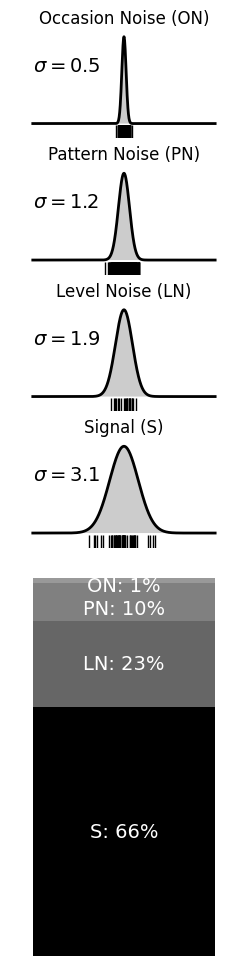

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as st

#--------------------------------------------------
# Helper Function: fcn_gaussian_plot (mimicking MATLAB)
#--------------------------------------------------
def fcn_gaussian_plot(ax, x, s, titleStr):
    """
    Mimics the MATLAB fcnGaussianPlot.
    Fits a Gaussian to data x (using a fixed sigma value s),
    plots vertical tick marks at y=-0.1, fills under the normalized Gaussian density,
    overlays the fitted curve, and adds a text label showing the fitted sigma.
    All ticks and axes are removed.
    """
    # Generate x values for plotting the fitted curve.
    xx = np.linspace(-20, 20, 1000)
    y = st.norm.pdf(xx, loc=0, scale=s)
    y = y / np.max(y)  # Normalize so that max(y)==1.
    
    # Plot vertical tick marks at each data point at y = -0.1.
    ax.plot(x, np.full_like(x, -0.1), 'k|', markersize=10)
    
    # Fill the area under the fitted curve.
    ax.fill_between(xx, 0, y, color=[0.8, 0.8, 0.8], edgecolor='none')
    # Plot the fitted Gaussian curve.
    ax.plot(xx, y, 'k', linewidth=2)
    
    # Add text showing the fitted sigma.
    ax.text(-20, 0.6, f"$\\sigma = {s:.1f}$", fontsize=14)
    
    # Remove ticks and axis labels.
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.set_title(titleStr)
    ax.set_xlim([-25, 25])

#--------------------------------------------------
# Helper Function: fcn_plot_stacked_bars_percent (vertical version using variance percentages)
#--------------------------------------------------
def fcn_plot_stacked_bars_percent(ax, perc_array, labels=None, on_offset=1):
    """
    Plots a vertical stacked bar using the given percentages.
    The input perc_array should be an array of percentages (e.g. [perc_c, perc_l, perc_p, perc_o])
    that sum to 100. The labels (if not provided) default to:
         ['S', 'LN', 'PN', 'ON'].
    Text labels are placed at the midpoint of each segment computed from the cumulative sum.
    For the top segment (Occasion Noise), the text is shifted downward by 'on_offset' units
    to ensure it is fully visible.
    """
    if labels is None:
        labels = ['S', 'LN', 'PN', 'ON']
    
    # Define colors (similar to MATLAB's cc matrix).
    cc = np.array([[0, 0, 0],
                   [0.4, 0.4, 0.4],
                   [0.5, 0.5, 0.5],
                   [0.6, 0.6, 0.6]])
    
    # Compute cumulative sums of percentages.
    cumsum_vals = np.cumsum(perc_array)
    prev = 0
    for i, val in enumerate(perc_array):
        # Compute the midpoint of the segment.
        mid = (prev + cumsum_vals[i]) / 2
        # For the top segment (last one: ON), shift the text down by on_offset units.
        if i == len(perc_array) - 1:
            mid = mid - 1.5
        if i == len(perc_array) - 2:
            mid = mid - 2
        ax.bar(0, val, bottom=prev, color=cc[i], width=0.8, edgecolor='none')
        ax.text(0, mid, f"{labels[i]}: {val:.0f}%", ha='center', va='center', color='white', fontsize=14)
        prev = cumsum_vals[i]
    
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(0, 100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

#--------------------------------------------------
# Data Extraction from MCMC (Replace with your actual trace)
#--------------------------------------------------
# Extract posterior samples for the scale parameters (flattening across chains and draws)
sigma_c_samples = trace.posterior['sigma_c'].values.flatten()
sigma_l_samples = trace.posterior['sigma_l'].values.flatten()
sigma_p_samples = trace.posterior['sigma_p'].values.flatten()
sigma_o_samples = trace.posterior['sigma_o'].values.flatten()

# Compute the variance for each component (variance = sigma^2)
var_c = np.mean(sigma_c_samples ** 2)
var_l = np.mean(sigma_l_samples ** 2)
var_p = np.mean(sigma_p_samples ** 2)
var_o = np.mean(sigma_o_samples ** 2)

# Calculate the total variance as the sum of the four component variances
total_variance = var_c + var_l + var_p + var_o

# Compute percentage contributions based on variances.
perc_c = (var_c / total_variance) * 100
perc_l = (var_l / total_variance) * 100
perc_p = (var_p / total_variance) * 100
perc_o = (var_o / total_variance) * 100

print("\nVariance Decomposition:")
print(f"Total Variance (sum of components): {total_variance:.3f}")
print("Percentage contributions:")
print(f"  Signal (case) variance:         {perc_c:.2f}%")
print(f"  Level noise (expert) variance:    {perc_l:.2f}%")
print(f"  Pattern noise (interaction) variance: {perc_p:.2f}%")
print(f"  Occasion noise (observation-level) variance: {perc_o:.2f}%")

# Compute effective scale estimates as the square roots of the variances.
S_est = np.sqrt(var_c)
LN_est = np.sqrt(var_l)
PN_est = np.sqrt(var_p)
ON_est = np.sqrt(var_o)

print("\nEffective scale estimates:")
print(f"Signal (S): {S_est:.2f}")
print(f"Level Noise (LN): {LN_est:.2f}")
print(f"Pattern Noise (PN): {PN_est:.2f}")
print(f"Occasion Noise (ON): {ON_est:.2f}")

#--------------------------------------------------
# Create the Figure Layout using GridSpec
#--------------------------------------------------
fig = plt.figure(figsize=(10, 12))
# Mimic a 7x3 grid; here we use only the first column.
gs = gridspec.GridSpec(7, 3, figure=fig, hspace=0.3)

# Gaussian plot for Occasion Noise (ON) at position (row 0, col 0)
ax1 = fig.add_subplot(gs[0, 0])
x_on = np.random.randn(50 * 20) * ON_est
fcn_gaussian_plot(ax1, x_on, ON_est, "Occasion Noise (ON)")

# Gaussian plot for Pattern Noise (PN) at position (row 1, col 0)
ax2 = fig.add_subplot(gs[1, 0])
x_pn = np.random.randn(20 * 50) * PN_est
fcn_gaussian_plot(ax2, x_pn, PN_est, "Pattern Noise (PN)")

# Gaussian plot for Level Noise (LN) at position (row 2, col 0)
ax3 = fig.add_subplot(gs[2, 0])
x_ln = np.random.randn(20) * LN_est
fcn_gaussian_plot(ax3, x_ln, LN_est, "Level Noise (LN)")

# Gaussian plot for Signal (S) at position (row 3, col 0)
ax4 = fig.add_subplot(gs[3, 0])
x_s = np.random.randn(50) * S_est
fcn_gaussian_plot(ax4, x_s, S_est, "Signal (S)")

# Vertical Stacked Bar Plot in the lower panel spanning rows 4 to 7 in the first column.
ax5 = fig.add_subplot(gs[4:, 0])
perc_array = [perc_c, perc_l, perc_p, perc_o]
fcn_plot_stacked_bars_percent(ax5, perc_array)

plt.tight_layout()
plt.show()
